In [1]:
import os
import gc
import sys
import time
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from apex import amp
import torchvision
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from efficientnet_pytorch import model as enet
import albumentations
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from tqdm.notebook import tqdm
DEVICE = torch.device('cuda')
for i in range(torch.cuda.device_count()):
    print(i, torch.cuda.get_device_name(i))
    print('  allocated:', round(torch.cuda.memory_allocated(i) / 1024 ** 3, 1), 'GB')
    print('  cached:   ', round(torch.cuda.memory_cached(i) / 1024 ** 3, 1), 'GB')

0 Graphics Device
  allocated: 0.0 GB
  cached:    0.0 GB
1 Graphics Device
  allocated: 0.0 GB
  cached:    0.0 GB


In [2]:
MAIN_PATH = '.'
DATA_PATH = '{}/data'.format(MAIN_PATH)
LABELS_PATH = '{}/train.csv'.format(DATA_PATH)
DEBUG = False
APEX = True
M_PARAMS = {
    'MODEL_VER': 'v13',
    'TILES_DIR': '{}/train_images_tiles_q1_256_36/'.format(DATA_PATH),
    'ENET_TYPE': 'efficientnet-b0',
    'N_FOLDS': 5,
    'TILE_SIZE': 256,
    'N_TILES': 25,
    'BATCH_SIZE': 8,
    'N_WORKERS': 24,
    'OUT_DIM': 5,
    'LR': 3e-4,
    'N_EPOCHS': 10 if DEBUG else 40,
    'WARMUP': True,
    'COMMENTS': 'seed 2020'
}
print(M_PARAMS)
MODELS_PATH = '{}/effnet_models_{}'.format(MAIN_PATH, M_PARAMS['MODEL_VER'])
if not os.path.exists(MODELS_PATH):
    os.mkdir(MODELS_PATH)
    print('created:', MODELS_PATH)
PRETRAINED_MODEL = {
    'efficientnet-b0': './bbs/efficientnet-b0-355c32eb.pth',
    'efficientnet-b1': './bbs/efficientnet-b1-f1951068.pth',
    'efficientnet-b2': './bbs/efficientnet-b2-8bb594d6.pth',
    'efficientnet-b3': './bbs/efficientnet-b3-5fb5a3c3.pth'
}

{'MODEL_VER': 'v13', 'TILES_DIR': './data/train_images_tiles_q1_256_36/', 'ENET_TYPE': 'efficientnet-b0', 'N_FOLDS': 5, 'TILE_SIZE': 256, 'N_TILES': 25, 'BATCH_SIZE': 8, 'N_WORKERS': 24, 'OUT_DIM': 5, 'LR': 0.0003, 'N_EPOCHS': 40, 'WARMUP': True, 'COMMENTS': 'seed 2020'}


In [3]:
if DEBUG:
    df_train = pd.read_csv(os.path.join(DATA_PATH, 'train_dsph.csv')).sample(100).reset_index(drop=True)
else:
    df_train = pd.read_csv(os.path.join(DATA_PATH, 'train_dsph.csv'))
df_train.head()

,Unnamed: 0,image_id,data_provider,isup_grade,gleason_score
0,0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [4]:
skf = StratifiedKFold(M_PARAMS['N_FOLDS'], shuffle=True, random_state=2020)
df_train['fold'] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(df_train, df_train['isup_grade'])):
    df_train.loc[valid_idx, 'fold'] = i
df_train.head()

,Unnamed: 0,image_id,data_provider,isup_grade,gleason_score,fold
0,0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,0
1,1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,1
2,2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,1
3,3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,0
4,4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,1


In [5]:
class EffNet(nn.Module):
    def __init__(self, backbone, out_dim):
        super(EffNet, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        self.enet.load_state_dict(torch.load(PRETRAINED_MODEL[backbone]))
        #self.enet = enet.EfficientNet.from_pretrained(backbone)
        nc = self.enet._fc.in_features
        self.myfc = nn.Linear(nc, out_dim)
        self.enet._fc = nn.Identity()
        self.enet = nn.DataParallel(self.enet)
    def forward(self, x):
        x = self.enet(x)
        x = self.myfc(x)
        return x
class EffNet_(nn.Module):
    def __init__(self, backbone, out_dim):
        super(EffNet_, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        self.enet.load_state_dict(torch.load(PRETRAINED_MODEL[backbone]))
        nc = self.enet._fc.in_features
        self.enet._fc = nn.Identity()
        self.enet = nn.DataParallel(self.enet)
        self.myfc = nn.DataParallel(nn.Sequential(
            nn.Linear(nc, int(nc / 4)),
            nn.ELU(),
            nn.BatchNorm1d(int(nc / 4)), 
            nn.Dropout(.4),
            nn.Linear(int(nc / 4), out_dim)
        ))
    def extract(self, x):
        return self.enet(x)
    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(x)
        return x
class ResNext(nn.Module):
    def __init__(self, out_dim):
        super(ResNext, self).__init__()
        self.rsnxt = torchvision.models.resnext50_32x4d(pretrained=True)
        nc = self.rsnxt.fc.in_features
        self.rsnxt.fc = nn.Sequential(
            Flatten(),
            nn.Linear(nc, int(nc / 2)),
            nn.ReLU(),
            nn.BatchNorm1d(int(nc / 2)), 
            nn.Dropout(.4),
            nn.Linear(int(nc / 2), out_dim)
        )
        self.rsnxt = nn.DataParallel(self.rsnxt)
    def forward(self, x):
        x = self.rsnxt(x)
        return x

In [6]:
def get_tiles(img_id, n_tiles):
        result = []
        seq_imgs = []
        for i in range(n_tiles):
            img_path = '{}/{}_{}.png'.format(M_PARAMS['TILES_DIR'], img_id, i)
            img = cv2.imread(img_path)
            if not np.any(img):
                print('no img file read:', img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            seq_imgs.append(img)
        for i in range(len(seq_imgs)):
            result.append({'img':seq_imgs[i], 'idx':i})
        return result
class PANDADataset(Dataset):
    def __init__(self, df, tile_size, n_tiles, tile_mode=0, rand=False,
                 transform=None, transform_tile=None):
        self.df = df.reset_index(drop=True)
        self.tile_size = tile_size
        self.n_tiles = n_tiles
        self.tile_mode = tile_mode
        self.rand = rand
        self.transform = transform
        self.transform_tile = transform_tile
    def __len__(self):
        return self.df.shape[0]
    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        tiles = get_tiles(img_id, self.n_tiles)
        if self.rand:
            idxes = np.random.choice(list(range(self.n_tiles)), self.n_tiles, replace=False)
        else:
            idxes = list(range(self.n_tiles))
        n_row_tiles = int(np.sqrt(self.n_tiles))
        images = np.zeros((self.tile_size * n_row_tiles, self.tile_size * n_row_tiles, 3))
        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w
                if len(tiles) > idxes[i]:
                    this_img = tiles[idxes[i]]['img']
                else:
                    this_img = np.ones((self.tile_size, self.tile_size, 3)).astype(np.uint8) * 255
                this_img = (255 - this_img) / 255
                if self.transform_tile is not None:
                    this_img = self.transform_tile(image=this_img)['image']
                h1 = h * self.tile_size
                w1 = w * self.tile_size
                images[h1 : h1 + self.tile_size, w1:w1 + self.tile_size] = this_img
        images = images.astype(np.float32)
        if self.transform is not None:
            images = self.transform(image=images)['image']
        images = images.transpose(2, 0, 1)
        label = np.zeros(5).astype(np.float32)
        label[:row.isup_grade] = 1.
        return torch.tensor(images), torch.tensor(label)

In [7]:
transforms_train = albumentations.Compose(
    [
        albumentations.OneOf(
            [
                albumentations.RandomBrightness(limit=.1), 
                albumentations.RandomContrast(limit=.1), 
                albumentations.RandomGamma()
            ], 
            p=.33
        ),
        albumentations.Transpose(p=.5),
        albumentations.VerticalFlip(p=.5),
        albumentations.HorizontalFlip(p=.5),
        albumentations.Rotate(limit=15, p=.33)
    ]
)
transforms_train_tile = albumentations.Compose(
    [
        albumentations.Transpose(p=.5),
        albumentations.VerticalFlip(p=.5),
        albumentations.HorizontalFlip(p=.5)
    ]
)

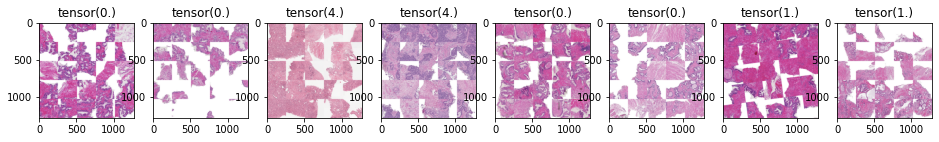

In [8]:
dataset_show = PANDADataset(
    df_train,
    M_PARAMS['TILE_SIZE'], 
    M_PARAMS['N_TILES'], 
    tile_mode=0, 
    transform=transforms_train,
    transform_tile=transforms_train_tile
)
from pylab import rcParams
rcParams['figure.figsize'] = (16, 4)
f, axarr = plt.subplots(1, M_PARAMS['BATCH_SIZE'])
for i in range(M_PARAMS['BATCH_SIZE']):
    img, label = dataset_show.__getitem__(i)
    axarr[i].imshow(1. - img.transpose(0, 1).transpose(1,2).squeeze())
    axarr[i].set_title(str(sum(label)))

In [9]:
criterion = nn.BCEWithLogitsLoss()
def train_epoch(loader, optimizer):
    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        data, target = data.to(DEVICE), target.to(DEVICE)
        loss_func = criterion
        optimizer.zero_grad()
        logits = model(data)
        loss = loss_func(logits, target)
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
        #loss.backward()
        optimizer.step()
        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss
def val_epoch(loader, get_output=False):
    model.eval()
    val_loss = []
    LOGITS = []
    PREDS = []
    TARGETS = []
    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(DEVICE), target.to(DEVICE)
            logits = model(data)
            loss = criterion(logits, target)
            pred = logits.sigmoid().sum(1).detach().round()
            LOGITS.append(logits)
            PREDS.append(pred)
            TARGETS.append(target.sum(1))
            val_loss.append(loss.detach().cpu().numpy())
        val_loss = np.mean(val_loss)
    LOGITS = torch.cat(LOGITS).cpu().numpy()
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    acc = (PREDS == TARGETS).mean() * 100.
    qwk = cohen_kappa_score(PREDS, TARGETS, weights='quadratic')
    qwk_k = cohen_kappa_score(
        PREDS[df_valid['data_provider'] == 'karolinska'], 
        df_valid[df_valid['data_provider'] == 'karolinska'].isup_grade.values, 
        weights='quadratic'
    )
    qwk_r = cohen_kappa_score(
        PREDS[df_valid['data_provider'] == 'radboud'], 
        df_valid[df_valid['data_provider'] == 'radboud'].isup_grade.values, 
        weights='quadratic'
    )
    print('QWK', qwk, 'QWK_k', qwk_k, 'QWK_r', qwk_r)
    if get_output:
        return LOGITS
    else:
        return val_loss, acc, qwk

In [ ]:
pred, target = [], []
if DEBUG:
    n_folds_train = 2
else:
    n_folds_train = M_PARAMS['N_FOLDS']
start_folds_train = 0
for fold_num in range(start_folds_train, n_folds_train):
    print('-' * 20, 'fold:', fold_num, '-' * 20)
    train_idx = np.where((df_train['fold'] != fold_num))[0]
    valid_idx = np.where((df_train['fold'] == fold_num))[0]
    df_this  = df_train.loc[train_idx]
    df_valid = df_train.loc[valid_idx]
    dataset_train = PANDADataset(
        df_this, 
        M_PARAMS['TILE_SIZE'], 
        M_PARAMS['N_TILES'], 
        transform=transforms_train,
        transform_tile=transforms_train_tile
    )
    dataset_valid = PANDADataset(
        df_valid, 
        M_PARAMS['TILE_SIZE'], 
        M_PARAMS['N_TILES']
    )
    train_loader = torch.utils.data.DataLoader(
        dataset_train, 
        batch_size=M_PARAMS['BATCH_SIZE'], 
        sampler=RandomSampler(dataset_train), 
        num_workers=M_PARAMS['N_WORKERS']
    )
    valid_loader = torch.utils.data.DataLoader(
        dataset_valid, 
        batch_size=M_PARAMS['BATCH_SIZE'], 
        sampler=SequentialSampler(dataset_valid), 
        num_workers=M_PARAMS['N_WORKERS']
    )
    model = EffNet(M_PARAMS['ENET_TYPE'], out_dim=M_PARAMS['OUT_DIM']) 
    #model = ResNext(out_dim=OUT_DIM)
    model = model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=M_PARAMS['LR'])
    model, optimizer = amp.initialize(model, optimizer, opt_level='O1')
    if M_PARAMS['WARMUP']:
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, 
            max_lr=M_PARAMS['LR'], 
            total_steps=M_PARAMS['N_EPOCHS'],
            div_factor=30, 
            final_div_factor=1000,
            pct_start=(2 / M_PARAMS['N_EPOCHS']),
        )
    else:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, M_PARAMS['N_EPOCHS'])
    print('train len:', len(dataset_train),'| val len:', len(dataset_valid))
    qwk_max = 0
    best_file = '{}/{}_best_fold{}.pth'.format(MODELS_PATH, M_PARAMS['ENET_TYPE'], fold_num)
    for epoch in tqdm(range(M_PARAMS['N_EPOCHS']), desc='epochs'):
        print(time.ctime(), 'epoch:', epoch)
        train_loss = train_epoch(train_loader, optimizer)
        val_loss, acc, qwk = val_epoch(valid_loader)
        scheduler.step(epoch)
        content = '{} epoch {}, lr: {:.8f}, train loss: {:.4f}, val loss: {:.4f}, acc: {:.1f}, QWK: {:.4f}'.format(
                time.ctime(),
                epoch, 
                optimizer.param_groups[0]['lr'], 
                np.mean(train_loss),
                np.mean(val_loss),
                acc,
                qwk
            )
        print(content)
        with open('{}/log_{}_fold{}.txt'.format(MODELS_PATH, M_PARAMS['ENET_TYPE'], fold_num), 'a') as appender:
            appender.write(content + '\n')
        if qwk > qwk_max:
            torch.save(model.state_dict(), best_file)
            print('QWK improved {:.6f} --> {:.6f} model saved'.format(qwk_max, qwk))
            qwk_max = qwk
    with open('{}/log_{}_folds_all.txt'.format(MODELS_PATH, M_PARAMS['ENET_TYPE']), 'a') as appender:
        appender.write('{} | fold: {} | max QWK: {:.6f}\n'.format(M_PARAMS, fold_num, qwk_max))
    torch.save(
        model.state_dict(), 
        os.path.join('{}/{}_final_fold{}.pth'.format(MODELS_PATH, M_PARAMS['ENET_TYPE'], fold_num))
    )
    del model, dataset_train, dataset_valid, train_loader, valid_loader
    torch.cuda.empty_cache()
    gc.collect()

-------------------- fold: 0 --------------------
Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
train len: 8412 | val len: 2104


Thu Jul  9 17:50:32 2020 epoch: 0



QWK 0.5808922708297077 QWK_k 0.5011806391792488 QWK_r 0.49495994268351406
Thu Jul  9 18:04:38 2020 epoch 0, lr: 0.00001000, train loss: 0.5317, val loss: 0.3883, acc: 28.0, QWK: 0.5809
QWK improved 0.000000 --> 0.580892 model saved
Thu Jul  9 18:04:38 2020 epoch: 1


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0




QWK 0.6962394467374682 QWK_k 0.6714133409253576 QWK_r 0.6337209905578804
Thu Jul  9 18:18:38 2020 epoch 1, lr: 0.00030000, train loss: 0.4127, val loss: 0.3356, acc: 36.3, QWK: 0.6962
QWK improved 0.580892 --> 0.696239 model saved
Thu Jul  9 18:18:38 2020 epoch: 2



QWK 0.8157013804713473 QWK_k 0.7955346496693804 QWK_r 0.7772321583970927
Thu Jul  9 18:32:38 2020 epoch 2, lr: 0.00029949, train loss: 0.3680, val loss: 0.2725, acc: 54.5, QWK: 0.8157
QWK improved 0.696239 --> 0.815701 model saved
Thu Jul  9 18:32:38 2020 epoch: 3


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0




QWK 0.8300428968415298 QWK_k 0.8325893580641996 QWK_r 0.7842601133062104
Thu Jul  9 18:46:38 2020 epoch 3, lr: 0.00029795, train loss: 0.3023, val loss: 0.2699, acc: 58.7, QWK: 0.8300
QWK improved 0.815701 --> 0.830043 model saved
Thu Jul  9 18:46:38 2020 epoch: 4


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0




QWK 0.8197529287824078 QWK_k 0.8289491013835238 QWK_r 0.7706484051400389
Thu Jul  9 19:00:39 2020 epoch 4, lr: 0.00029541, train loss: 0.2750, val loss: 0.2605, acc: 60.0, QWK: 0.8198
Thu Jul  9 19:00:39 2020 epoch: 5



QWK 0.8422640946951159 QWK_k 0.8556295653033011 QWK_r 0.7917250805946324
Thu Jul  9 19:14:39 2020 epoch 5, lr: 0.00029187, train loss: 0.2545, val loss: 0.2689, acc: 53.8, QWK: 0.8423
QWK improved 0.830043 --> 0.842264 model saved
Thu Jul  9 19:14:39 2020 epoch: 6


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0




QWK 0.851689760210439 QWK_k 0.8736963931802051 QWK_r 0.8020463678795816
Thu Jul  9 19:28:41 2020 epoch 6, lr: 0.00028737, train loss: 0.2442, val loss: 0.2299, acc: 62.5, QWK: 0.8517
QWK improved 0.842264 --> 0.851690 model saved
Thu Jul  9 19:28:41 2020 epoch: 7



QWK 0.8479919360847373 QWK_k 0.854405301532817 QWK_r 0.8024735303878641
Thu Jul  9 19:42:41 2020 epoch 7, lr: 0.00028192, train loss: 0.2355, val loss: 0.2337, acc: 63.0, QWK: 0.8480
Thu Jul  9 19:42:41 2020 epoch: 8


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0




QWK 0.8460404603839062 QWK_k 0.8644138081360575 QWK_r 0.7962290821430223
Thu Jul  9 19:56:41 2020 epoch 8, lr: 0.00027558, train loss: 0.2304, val loss: 0.2335, acc: 64.1, QWK: 0.8460
Thu Jul  9 19:56:41 2020 epoch: 9


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0




QWK 0.8634483891374771 QWK_k 0.8700635265433917 QWK_r 0.825139039925431
Thu Jul  9 20:10:42 2020 epoch 9, lr: 0.00026837, train loss: 0.2221, val loss: 0.2149, acc: 62.9, QWK: 0.8634
QWK improved 0.851690 --> 0.863448 model saved
Thu Jul  9 20:10:42 2020 epoch: 10



QWK 0.819735174196427 QWK_k 0.8231548401605935 QWK_r 0.7789242016187268
Thu Jul  9 20:24:44 2020 epoch 10, lr: 0.00026036, train loss: 0.2139, val loss: 0.2810, acc: 60.6, QWK: 0.8197
Thu Jul  9 20:24:44 2020 epoch: 11


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0




QWK 0.8687379641017611 QWK_k 0.8783461270417792 QWK_r 0.8249174744820934
Thu Jul  9 20:38:46 2020 epoch 11, lr: 0.00025159, train loss: 0.2100, val loss: 0.2230, acc: 61.8, QWK: 0.8687
QWK improved 0.863448 --> 0.868738 model saved
Thu Jul  9 20:38:46 2020 epoch: 12



QWK 0.8736613042108495 QWK_k 0.8757742262258142 QWK_r 0.8368067468595796
Thu Jul  9 20:52:46 2020 epoch 12, lr: 0.00024213, train loss: 0.1994, val loss: 0.2143, acc: 64.9, QWK: 0.8737
QWK improved 0.868738 --> 0.873661 model saved
Thu Jul  9 20:52:46 2020 epoch: 13



QWK 0.8671920256731253 QWK_k 0.8707893698394753 QWK_r 0.8322687124906554
Thu Jul  9 21:06:47 2020 epoch 13, lr: 0.00023204, train loss: 0.1944, val loss: 0.2138, acc: 66.9, QWK: 0.8672
Thu Jul  9 21:06:47 2020 epoch: 14



QWK 0.8542938595171746 QWK_k 0.8423732555947046 QWK_r 0.8249209488990004
Thu Jul  9 21:20:47 2020 epoch 14, lr: 0.00022139, train loss: 0.1905, val loss: 0.2163, acc: 66.5, QWK: 0.8543
Thu Jul  9 21:20:47 2020 epoch: 15


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0




QWK 0.8887694429145175 QWK_k 0.8932669194460816 QWK_r 0.85743226398029
Thu Jul  9 21:34:48 2020 epoch 15, lr: 0.00021026, train loss: 0.1802, val loss: 0.1982, acc: 65.9, QWK: 0.8888
QWK improved 0.873661 --> 0.888769 model saved
Thu Jul  9 21:34:49 2020 epoch: 16



QWK 0.8703142188678303 QWK_k 0.8733428621548216 QWK_r 0.8332367765775416
Thu Jul  9 21:48:49 2020 epoch 16, lr: 0.00019871, train loss: 0.1791, val loss: 0.2166, acc: 66.3, QWK: 0.8703
Thu Jul  9 21:48:49 2020 epoch: 17



QWK 0.88109079480028 QWK_k 0.8889053004967514 QWK_r 0.8483434806191363
Thu Jul  9 22:02:50 2020 epoch 17, lr: 0.00018683, train loss: 0.1686, val loss: 0.2168, acc: 67.7, QWK: 0.8811
Thu Jul  9 22:02:50 2020 epoch: 18


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0




QWK 0.8913737547533503 QWK_k 0.8946958366084575 QWK_r 0.8621136604763795
Thu Jul  9 22:16:50 2020 epoch 18, lr: 0.00017469, train loss: 0.1622, val loss: 0.2003, acc: 67.5, QWK: 0.8914
QWK improved 0.888769 --> 0.891374 model saved
Thu Jul  9 22:16:50 2020 epoch: 19


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0




QWK 0.8805496082093378 QWK_k 0.893449849702184 QWK_r 0.8454464788013246
Thu Jul  9 22:30:51 2020 epoch 19, lr: 0.00016239, train loss: 0.1583, val loss: 0.2186, acc: 69.0, QWK: 0.8805
Thu Jul  9 22:30:51 2020 epoch: 20



QWK 0.8866700666919396 QWK_k 0.8815931989253634 QWK_r 0.8673486006916169
Thu Jul  9 22:44:51 2020 epoch 20, lr: 0.00015000, train loss: 0.1497, val loss: 0.2078, acc: 68.4, QWK: 0.8867
Thu Jul  9 22:44:51 2020 epoch: 21


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0




QWK 0.8953288759466722 QWK_k 0.8975269581441235 QWK_r 0.8672462375607266
Thu Jul  9 22:58:52 2020 epoch 21, lr: 0.00013762, train loss: 0.1456, val loss: 0.1963, acc: 66.7, QWK: 0.8953
QWK improved 0.891374 --> 0.895329 model saved
Thu Jul  9 22:58:52 2020 epoch: 22



QWK 0.8686552882067955 QWK_k 0.8803159025331708 QWK_r 0.8327828968078239
Thu Jul  9 23:12:52 2020 epoch 22, lr: 0.00012532, train loss: 0.1354, val loss: 0.2364, acc: 69.9, QWK: 0.8687
Thu Jul  9 23:12:52 2020 epoch: 23



QWK 0.8971234051258368 QWK_k 0.8915757938931724 QWK_r 0.8779515718472031
Thu Jul  9 23:26:53 2020 epoch 23, lr: 0.00011318, train loss: 0.1323, val loss: 0.1963, acc: 69.5, QWK: 0.8971
QWK improved 0.895329 --> 0.897123 model saved
Thu Jul  9 23:26:53 2020 epoch: 24
